# Exploring the Features of the Dataset

In [1]:
import sys
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm # colormap
import matplotlib.patches as mpatches # for legend making
import seaborn as sns
sys.path.append('/users/cody/github/CambridgeSemiticsLab/Gesenius_data/data')
from tf.fabric import Fabric
from tf.app import use
import tf_tools

# load BHSA features with genre module
locations = [
    '~/github/etcbc/bhsa/tf/c', 
    '~/github/etcbc/genre_synvar/tf/c',
    '~/github/etcbc/valence/tf/c'
]
TF = Fabric(locations)
extra_features = '''
domain txt ps gn 
nu genre sense
mother sp
'''
features = tf_tools.standard_features + extra_features
api = TF.load(features)
bhsa = use('bhsa', api=api)
F, E, T, L, Fs = bhsa.api.F, bhsa.api.E, bhsa.api.T, bhsa.api.L, bhsa.api.Fs

A = use('bhsa', api=api)

from clause_relas import in_dep_calc as clause_relator

This is Text-Fabric 8.4.4
Api reference : https://annotation.github.io/text-fabric/cheatsheet.html

125 features found and 0 ignored
  0.00s loading features ...
   |     0.00s Dataset without structure sections in otext:no structure functions in the T-API
  6.89s All features loaded/computed - for details use loadLog()


## Domain

In [2]:
def map_domain(node):
    """Map domains to be more permissive with Q"""
    txt_type = F.txt.v(node)
    if 'Q' in txt_type:
        return 'Q'
    else:
        return txt_type[-1]

In [3]:
len(list(F.otype.s('book')))

39

In [4]:
# build data for books

# assign each domain to an integer that aligns with 
# a color in a matplotlib color map
domain_ints = {
    'N': 0.1,
    'Q': 0.2,
    'D': 0.3,
    '?': 0.4,
}

# iterate through all books and add the data as a 
# an integer using the domain_ints dict above
# keep a mapping with an individidual book
book2domains = collections.defaultdict(list)
n_clauses = 0

for book in F.otype.s('book'):
    book_name = T.sectionFromNode(book)[0]
    for clause in L.d(book, 'clause'):
        book2domains[book_name].append(domain_ints[map_domain(clause)])
        n_clauses += 1
        
print(len(book2domains), 'books')
print(n_clauses, 'clauses')

39 books
88121 clauses


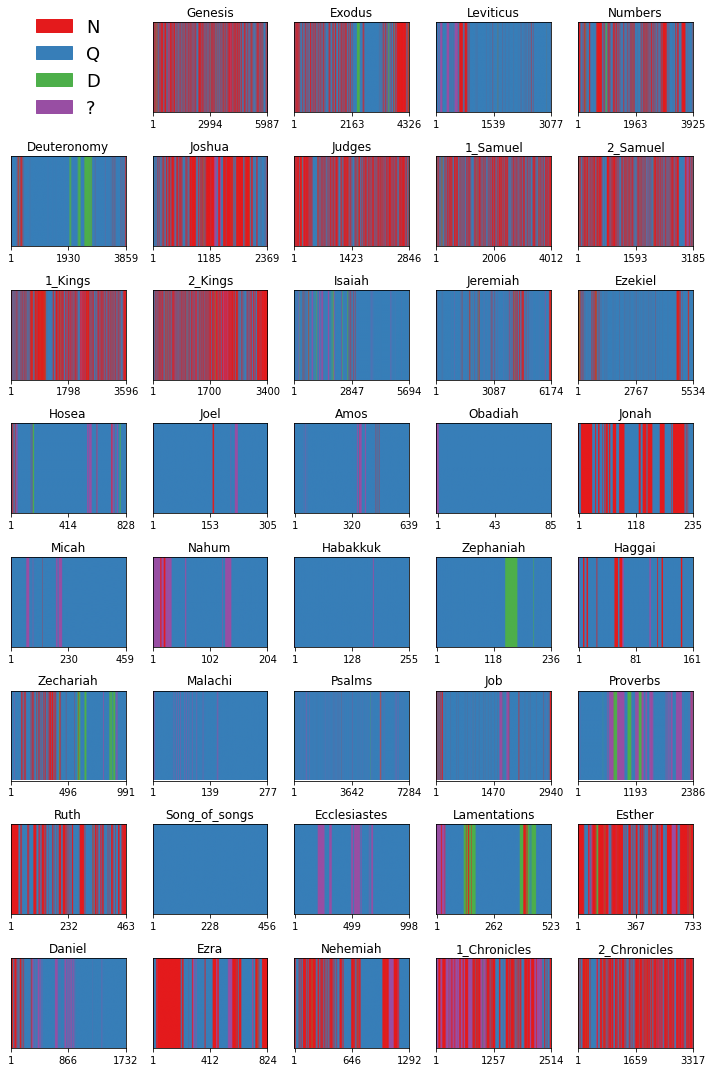

In [35]:
cmap = cm.get_cmap('Set1')

# build large plot for all books
fig, axs = plt.subplots(8, 5, figsize=(10, 15))
all_axs = axs.ravel()
lax = all_axs[0] # for legend
axs = all_axs[1:] # for all others

# build legend 
handles = [
    mpatches.Patch(color=cmap(i), label=k)
        for k, i in domain_ints.items()
]
lax.legend(handles=handles, loc='center', frameon=False, fontsize=18)
lax.set_yticks([])
lax.set_xticks([])
lax.axis('off')

for book, ax in zip(book2domains, axs):
    book_doms = book2domains[book]
    plot_category(book_doms, ax, cmap, book)
    
fig.tight_layout() # ensure spacing between the subplots

plt.savefig('/users/cody/Desktop/book_domains.png', dpi=300, bbox_inches='tight', facecolor='white', transparent=False)

# Genre

In [34]:
# build data for books

# assign each gen to an integer that aligns with 
# a color in a matplotlib color map
gen_ints = {
    'prose': 0.1,
    'poetry': 0.2,
    'prophetic': 0.3,
    'list': 0.4,
    'instruction': 0.5
}

# iterate through all books and add the data as a 
# an integer using the gen_ints dict above
# keep a mapping with an individidual book
book2gens = collections.defaultdict(list)
n_clauses = 0

for book in F.otype.s('book'):
    book_name = T.sectionFromNode(book)[0]
    for verse in L.d(book, 'verse'):
        book2gens[book_name].append(gen_ints[F.genre.v(verse)])
        n_clauses += 1
        
print(len(book2gens), 'books')
print(n_clauses, 'verses')

39 books
23213 verses


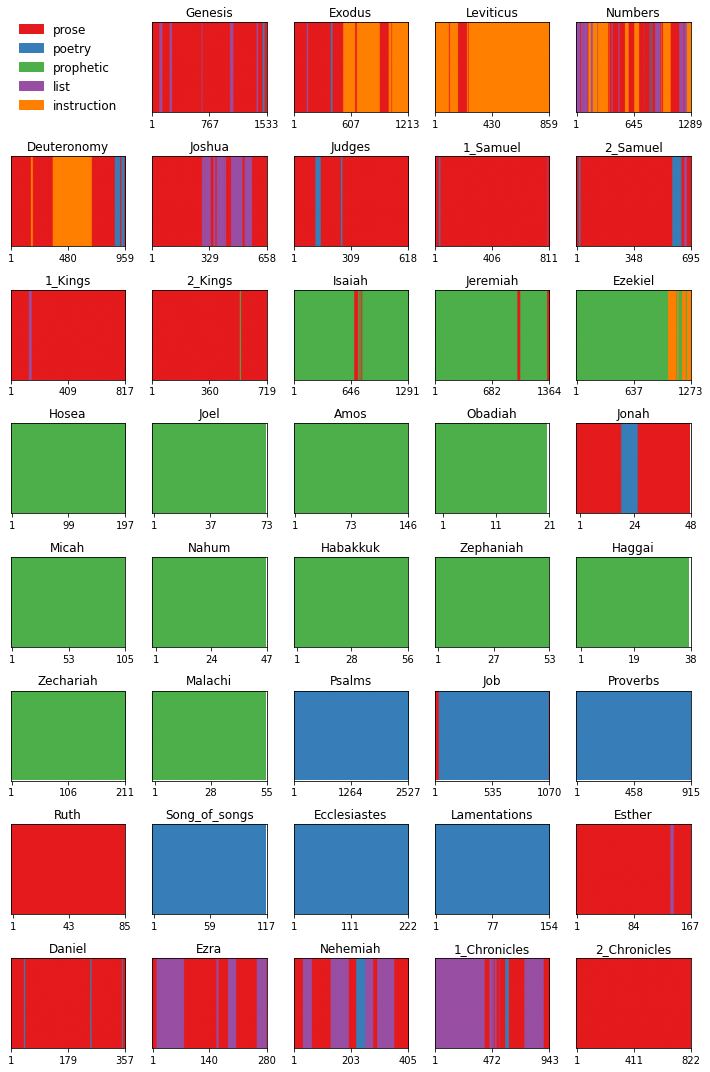

In [38]:
cmap = cm.get_cmap('Set1')
    
# build large plot for all books
fig, axs = plt.subplots(8, 5, figsize=(10, 15))
all_axs = axs.ravel()
lax = all_axs[0] # for legend
axs = all_axs[1:] # for all others

# build legend 
handles = [
    mpatches.Patch(color=cmap(i), label=k)
        for k, i in gen_ints.items()
]
lax.legend(handles=handles, loc='center', frameon=False, fontsize=12)
lax.set_yticks([])
lax.set_xticks([])
lax.axis('off')

for book, ax in zip(book2gens, axs):
    book_gens = book2gens[book]
    plot_category(book_gens, ax, cmap, book)
    
fig.tight_layout() # ensure spacing between the subplots

plt.savefig('/users/cody/Desktop/book_gens.png', dpi=300, bbox_inches='tight', facecolor='white', transparent=False)

# Verb Type

In [26]:
# verb_type_search = A.search('''

# word vt=ptcp|ptca sp=verb pdp#verb

# ''')

# A.show(verb_type_search[:10])

In [2]:
book2cltype = collections.defaultdict(list)

verb_map = {
    'impf': 'yqtl',
    'perf': 'qtl',
    'ptcp': 'ptcp',
    'ptca': 'ptcp',
}

unique_types = collections.Counter()

for book in F.otype.s('book'):
    
    book_name = T.sectionFromNode(book)[0]
    
    for clause in L.d(book, 'clause'):
        
        clause_rela = clause_relator(clause)
        if clause_rela != 'Main':
            continue
        
        verb_cands = [word for word in L.d(clause, 'word')
                         if F.pdp.v(word) == 'verb']
        
        # filter out non-predicative participles
        if len(verb_cands) > 1:
            verb_cands = [word for word in verb_cands
                             if F.vt.v(word) not in {'ptcp', 'ptca'}]
            
        if not verb_cands:
            clause_type = 'Ø'
            
        else:
            verb = verb_cands[0]
            vt = F.vt.v(verb)
            vt2 = verb_map.get(vt, vt)
            
            if vt2 == 'qtl' and F.lex.v(verb-1) == 'W':
                vt2 = 'wqtl'
                
            if vt2 in {'infa', 'infc'}:
                continue
                
            clause_type = vt2
            
        book2cltype[book_name].append(clause_type)
        unique_types[clause_type] += 1

In [3]:
print(len(book2cltype), 'books in the dataset...')
print(len(unique_types), 'unique clause types in the dataset...')
unique_types.most_common()

39 books in the dataset...
7 unique clause types in the dataset...


[('Ø', 15415),
 ('wayq', 14770),
 ('yqtl', 12573),
 ('qtl', 8985),
 ('wqtl', 6251),
 ('impv', 4287),
 ('ptcp', 2599)]

In [4]:
def plot_category(cldom_list, ax, cmap, title=''):
    """Take in a list of category data and plot it."""
    doms = np.array([cmap(i) for i in cldom_list]) # convert each value to RGB
    ax.imshow(doms[np.newaxis,:], aspect="auto")
    ax.set_yticks([])
    ax.set_xticks([1, np.ceil(len(cldom_list)/2), len(cldom_list)])
    ax.set_title(title)

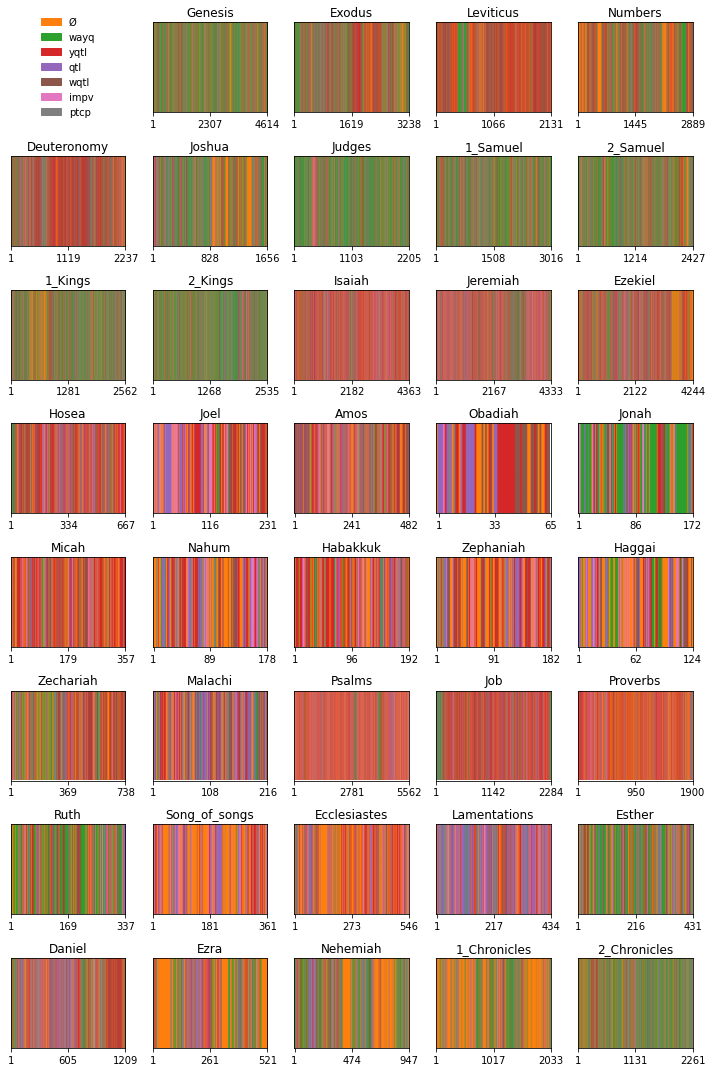

In [5]:
clause_ints = {
    'Ø': 0.1,
    'wayq': 0.2,
    'yqtl': 0.3,
    'qtl': 0.4,
    'wqtl': 0.5,
    'impv': 0.6,
    'ptcp': 0.7,
}

cmap = cm.get_cmap('tab10')
    
# build large plot for all books
fig, axs = plt.subplots(8, 5, figsize=(10, 15))
all_axs = axs.ravel()
lax = all_axs[0] # for legend
axs = all_axs[1:] # for all others

# build legend 
handles = [
    mpatches.Patch(color=cmap(i), label=k)
        for k, i in clause_ints.items()
]
lax.legend(handles=handles, loc='center', frameon=False, fontsize=10)
lax.set_yticks([])
lax.set_xticks([])
lax.axis('off')

for book, ax in zip(book2cltype, axs):
    book_clausetype = [clause_ints[cl] for cl in book2cltype[book]]
    plot_category(book_clausetype, ax, cmap, book)
    
fig.tight_layout() # ensure spacing between the subplots

plt.savefig('/users/cody/Desktop/book_clausetype.png', dpi=300, bbox_inches='tight', facecolor='white', transparent=False)